In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("./input"))

# Any results you write to the current directory are saved as output.

['test.csv', 'train.csv']


<a id="3"></a> <br>
### Logistic Regression
- Linear regression is not good at classification.
- We use logistic regression for classification.
- linear regression + logistic function(softmax) = logistic regression
- Check my deep learning tutorial. There is detailed explanation of logistic regression. 
    - https://www.kaggle.com/kanncaa1/deep-learning-tutorial-for-beginners
- **Steps of Logistic Regression**
    1. Import Libraries
    1. Prepare Dataset
        - We use MNIST dataset.
        - There are 28*28 images and 10 labels from 0 to 9
        - Data is not normalized so we divide each image to 255 that is basic normalization for images.
        - In order to split data, we use train_test_split method from sklearn library
        - Size of train data is 80% and size of test data is 20%.
        - Create feature and target tensors. At the next parts we create variable from these tensors. As you remember we need to define variable for accumulation of gradients.
        - batch_size = batch size means is that for example we have data and it includes 1000 sample. We can train 1000 sample in a same time or we can divide it 10 groups which include 100 sample and train 10 groups in order. Batch size is the group size. For example, I choose batch_size = 100, that means in order to train all data only once we have 336 groups. We train each groups(336) that have batch_size(quota) 100. Finally we train 33600 sample one time.
        - epoch: 1 epoch means training all samples one time.
        - In our example: we have 33600 sample to train and we decide our batch_size is 100. Also we decide epoch is 29(accuracy achieves almost highest value when epoch is 29). Data is trained 29 times. Question is that how many iteration do I need? Lets calculate: 
            - training data 1 times = training 33600 sample (because data includes 33600 sample) 
            - But we split our data 336 groups(group_size = batch_size = 100) our data 
            - Therefore, 1 epoch(training data only once) takes 336 iteration
            - We have 29 epoch, so total iterarion is 9744(that is almost 10000 which I used)
        - TensorDataset(): Data set wrapping tensors. Each sample is retrieved by indexing tensors along the first dimension.
        - DataLoader(): It combines dataset and sample. It also provides multi process iterators over the dataset.
        - Visualize one of the images in dataset
    1. Create Logistic Regression Model
        - Same with linear regression.
        - However as you expect, there should be logistic function in model right?
        - In pytorch, logistic function is in the loss function where we will use at next parts.
    1. Instantiate Model
        - input_dim = 28*28 # size of image px*px
        - output_dim = 10  # labels 0,1,2,3,4,5,6,7,8,9
        - create model
    1. Instantiate Loss 
        - Cross entropy loss
        - It calculates loss that is not surprise :)
        - It also has softmax(logistic function) in it.
    1. Instantiate Optimizer 
        - SGD Optimizer
    1. Traning the Model
    1. Prediction
- As a result, as you can see from plot, while loss decreasing, accuracy(almost 85%) is increasing and our model is learning(training).    

In [2]:
# Import Libraries
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
import pandas as pd
from sklearn.model_selection import train_test_split

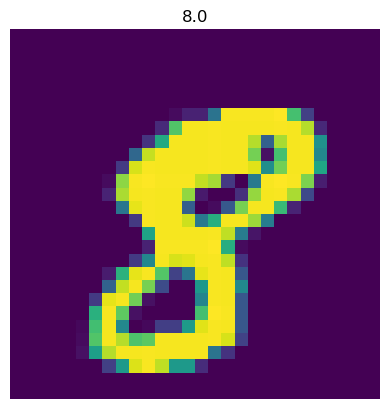

In [3]:
# Prepare Dataset
# load data
train = pd.read_csv(r"./input/train.csv",dtype = np.float32)

# split data into features(pixels) and labels(numbers from 0 to 9)
targets_numpy = train.label.values
features_numpy = train.loc[:,train.columns != "label"].values/255 # normalization

# train test split. Size of train data is 80% and size of test data is 20%. 
features_train, features_test, targets_train, targets_test = train_test_split(features_numpy,
                                                                             targets_numpy,
                                                                             test_size = 0.2,
                                                                             random_state = 42) 

# create feature and targets tensor for train set. As you remember we need variable to accumulate gradients. Therefore first we create tensor, then we will create variable
featuresTrain = torch.from_numpy(features_train)
targetsTrain = torch.from_numpy(targets_train).type(torch.LongTensor) # data type is long

# create feature and targets tensor for test set.
featuresTest = torch.from_numpy(features_test)
targetsTest = torch.from_numpy(targets_test).type(torch.LongTensor) # data type is long

# batch_size, epoch and iteration
batch_size = 100
n_iters = 10000
num_epochs = n_iters / (len(features_train) / batch_size)
num_epochs = int(num_epochs)

# Pytorch train and test sets
train = torch.utils.data.TensorDataset(featuresTrain,targetsTrain)
test = torch.utils.data.TensorDataset(featuresTest,targetsTest)

# data loader
train_loader = DataLoader(train, batch_size = batch_size, shuffle = False)
test_loader = DataLoader(test, batch_size = batch_size, shuffle = False)

# visualize one of the images in data set
plt.imshow(features_numpy[10].reshape(28,28))
plt.axis("off")
plt.title(str(targets_numpy[10]))
plt.savefig('graph.png')
plt.show()

In [4]:
# Create Logistic Regression Model
class LogisticRegressionModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LogisticRegressionModel, self).__init__()
        # Linear part
        self.linear = nn.Linear(input_dim, output_dim)
        # There should be logistic function right?
        # However logistic function in pytorch is in loss function
        # So actually we do not forget to put it, it is only at next parts
    
    def forward(self, x):
        out = self.linear(x)
        return out

# Instantiate Model Class
input_dim = 28*28 # size of image px*px
output_dim = 10  # labels 0,1,2,3,4,5,6,7,8,9

# create logistic regression model
model = LogisticRegressionModel(input_dim, output_dim)

# Cross Entropy Loss  
error = nn.CrossEntropyLoss()

# SGD Optimizer 
learning_rate = 0.001
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [5]:
# Traning the Model
count = 0
loss_list = []
iteration_list = []
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        
        # Define variables
        train = Variable(images.view(-1, 28*28))
        labels = Variable(labels)
        
        # Clear gradients
        optimizer.zero_grad()
        
        # Forward propagation
        outputs = model(train)
        
        # Calculate softmax and cross entropy loss
        loss = error(outputs, labels)
        
        # Calculate gradients
        loss.backward()
        
        # Update parameters
        optimizer.step()
        
        count += 1
        
        # Prediction
        if count % 50 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Predict test dataset
            for images, labels in test_loader: 
                test = Variable(images.view(-1, 28*28))
                
                # Forward propagation
                outputs = model(test)
                
                # Get predictions from the maximum value
                predicted = torch.max(outputs.data, 1)[1]
                
                # Total number of labels
                total += len(labels)
                
                # Total correct predictions
                correct += (predicted == labels).sum()
            
            accuracy = 100 * correct / float(total)
            
            # store loss and iteration
            loss_list.append(loss.data)
            iteration_list.append(count)
        if count % 500 == 0:
            # Print Loss
            print('Iteration: {}  Loss: {}  Accuracy: {}%'.format(count, loss.data, accuracy))

Iteration: 500  Loss: 1.8225200176239014  Accuracy: 67.58333587646484%
Iteration: 1000  Loss: 1.5828847885131836  Accuracy: 76.08333587646484%
Iteration: 1500  Loss: 1.2775826454162598  Accuracy: 78.51190185546875%
Iteration: 2000  Loss: 1.2045722007751465  Accuracy: 79.61904907226562%
Iteration: 2500  Loss: 1.0437469482421875  Accuracy: 80.73809814453125%
Iteration: 3000  Loss: 0.923136293888092  Accuracy: 81.57142639160156%
Iteration: 3500  Loss: 0.9023852348327637  Accuracy: 82.30952453613281%
Iteration: 4000  Loss: 0.7546080946922302  Accuracy: 82.77381134033203%
Iteration: 4500  Loss: 0.963276207447052  Accuracy: 83.23809814453125%
Iteration: 5000  Loss: 0.8005702495574951  Accuracy: 83.6547622680664%
Iteration: 5500  Loss: 0.7452430129051208  Accuracy: 83.89286041259766%
Iteration: 6000  Loss: 0.8711599111557007  Accuracy: 84.27381134033203%
Iteration: 6500  Loss: 0.6620324850082397  Accuracy: 84.5952377319336%
Iteration: 7000  Loss: 0.7077571153640747  Accuracy: 84.7619018554687

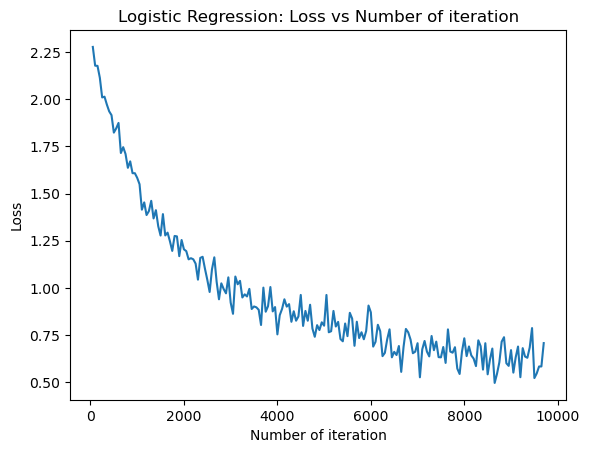

In [6]:
# visualization
plt.plot(iteration_list,loss_list)
plt.xlabel("Number of iteration")
plt.ylabel("Loss")
plt.title("Logistic Regression: Loss vs Number of iteration")
plt.show()

<a id="4"></a> <br>
### Artificial Neural Network (ANN)
- Logistic regression is good at classification but when complexity(non linearity) increases, the accuracy of model decreases.
- Therefore, we need to increase complexity of model.
- In order to increase complexity of model, we need to add more non linear functions as hidden layer. 
- I am saying again that if you do not know what is artificial neural network check my deep learning tutorial because I will not explain neural network detailed here, only explain pytorch.
- Artificial Neural Network tutorial: https://www.kaggle.com/kanncaa1/deep-learning-tutorial-for-beginners
- What we expect from artificial neural network is that when complexity increases, we use more hidden layers and our model can adapt better. As a result accuracy increase.
- **Steps of ANN:**
    1. Import Libraries
        - In order to show you, I import again but we actually imported them at previous parts.
    1. Prepare Dataset
        - Totally same with previous part(logistic regression).
        - We use same dataset so we only need train_loader and test_loader. 
        - We use same batch size, epoch and iteration numbers.
    1. Create ANN Model
        - We add 3 hidden layers.
        - We use ReLU, Tanh and ELU activation functions for diversity.
    1. Instantiate Model Class
        - input_dim = 28*28 # size of image px*px
        - output_dim = 10  # labels 0,1,2,3,4,5,6,7,8,9
        - Hidden layer dimension is 150. I only choose it as 150 there is no reason. Actually hidden layer dimension is hyperparameter and it should be chosen and tuned. You can try different values for hidden layer dimension and observe the results.
        - create model
    1. Instantiate Loss
        - Cross entropy loss
        - It also has softmax(logistic function) in it.
    1. Instantiate Optimizer
        - SGD Optimizer
    1. Traning the Model
    1. Prediction
- As a result, as you can see from plot, while loss decreasing, accuracy is increasing and our model is learning(training). 
- Thanks to hidden layers model learnt better and accuracy(almost 95%) is better than accuracy of logistic regression model.

In [7]:
# Import Libraries
import torch
import torch.nn as nn
from torch.autograd import Variable

In [8]:
# Create ANN Model
class ANNModel(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(ANNModel, self).__init__()
        
        # Linear function 1: 784 --> 150
        self.fc1 = nn.Linear(input_dim, hidden_dim) 
        # Non-linearity 1
        self.relu1 = nn.ReLU()
        
        # Linear function 2: 150 --> 150
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        # Non-linearity 2
        self.tanh2 = nn.Tanh()
        
        # Linear function 3: 150 --> 150
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        # Non-linearity 3
        self.elu3 = nn.ELU()
        
        # Linear function 4 (readout): 150 --> 10
        self.fc4 = nn.Linear(hidden_dim, output_dim)  
    
    def forward(self, x):
        # Linear function 1
        out = self.fc1(x)
        # Non-linearity 1
        out = self.relu1(out)
        
        # Linear function 2
        out = self.fc2(out)
        # Non-linearity 2
        out = self.tanh2(out)
        
        # Linear function 2
        out = self.fc3(out)
        # Non-linearity 2
        out = self.elu3(out)
        
        # Linear function 4 (readout)
        out = self.fc4(out)
        return out

# instantiate ANN
input_dim = 28*28
hidden_dim = 150 #hidden layer dim is one of the hyper parameter and it should be chosen and tuned. For now I only say 150 there is no reason.
output_dim = 10

# Create ANN
model = ANNModel(input_dim, hidden_dim, output_dim)

# Cross Entropy Loss 
error = nn.CrossEntropyLoss()

# SGD Optimizer
learning_rate = 0.02
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [9]:
# ANN model training
count = 0
loss_list = []
iteration_list = []
accuracy_list = []
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):

        train = Variable(images.view(-1, 28*28))
        labels = Variable(labels)
        
        # Clear gradients
        optimizer.zero_grad()
        
        # Forward propagation
        outputs = model(train)
        
        # Calculate softmax and ross entropy loss
        loss = error(outputs, labels)
        
        # Calculating gradients
        loss.backward()
        
        # Update parameters
        optimizer.step()
        
        count += 1
        
        if count % 50 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Predict test dataset
            for images, labels in test_loader:

                test = Variable(images.view(-1, 28*28))
                
                # Forward propagation
                outputs = model(test)
                
                # Get predictions from the maximum value
                predicted = torch.max(outputs.data, 1)[1]
                
                # Total number of labels
                total += len(labels)

                # Total correct predictions
                correct += (predicted == labels).sum()
            
            accuracy = 100 * correct / float(total)
            
            # store loss and iteration
            loss_list.append(loss.data)
            iteration_list.append(count)
            accuracy_list.append(accuracy)
        if count % 500 == 0:
            # Print Loss
            print('Iteration: {}  Loss: {}  Accuracy: {} %'.format(count, loss.data, accuracy))

Iteration: 500  Loss: 0.8229489922523499  Accuracy: 77.5952377319336 %
Iteration: 1000  Loss: 0.5249130129814148  Accuracy: 86.9047622680664 %
Iteration: 1500  Loss: 0.24053412675857544  Accuracy: 89.30952453613281 %
Iteration: 2000  Loss: 0.3055071532726288  Accuracy: 90.58333587646484 %
Iteration: 2500  Loss: 0.31981879472732544  Accuracy: 91.88095092773438 %
Iteration: 3000  Loss: 0.12295215576887131  Accuracy: 92.48809814453125 %
Iteration: 3500  Loss: 0.26730549335479736  Accuracy: 93.19047546386719 %
Iteration: 4000  Loss: 0.06549032777547836  Accuracy: 93.6547622680664 %
Iteration: 4500  Loss: 0.32711508870124817  Accuracy: 94.1547622680664 %
Iteration: 5000  Loss: 0.1086726114153862  Accuracy: 94.41666412353516 %
Iteration: 5500  Loss: 0.1897023618221283  Accuracy: 94.61904907226562 %
Iteration: 6000  Loss: 0.19963482022285461  Accuracy: 94.8452377319336 %
Iteration: 6500  Loss: 0.09269607812166214  Accuracy: 95.32142639160156 %
Iteration: 7000  Loss: 0.11558521538972855  Accur

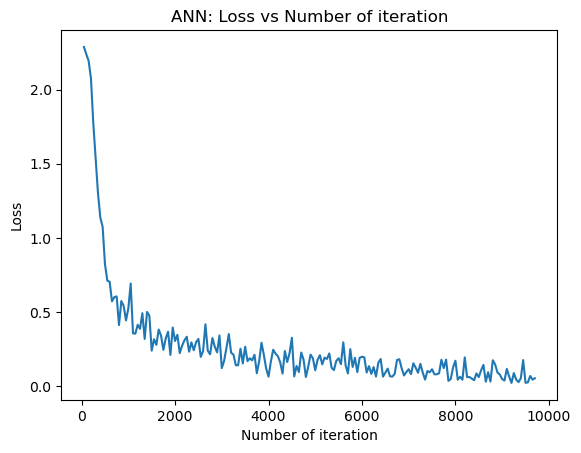

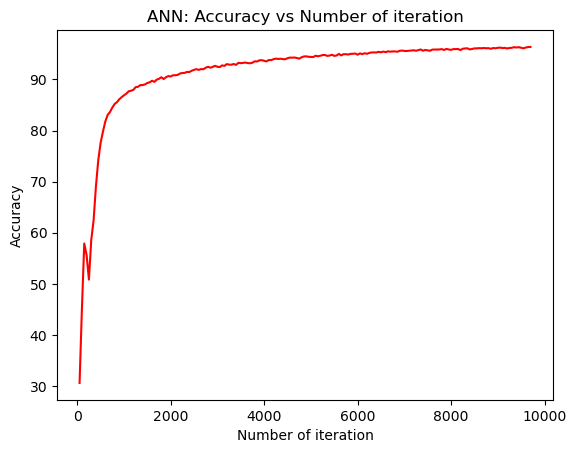

In [10]:
# visualization loss 
plt.plot(iteration_list,loss_list)
plt.xlabel("Number of iteration")
plt.ylabel("Loss")
plt.title("ANN: Loss vs Number of iteration")
plt.show()

# visualization accuracy 
plt.plot(iteration_list,accuracy_list,color = "red")
plt.xlabel("Number of iteration")
plt.ylabel("Accuracy")
plt.title("ANN: Accuracy vs Number of iteration")
plt.show()

<a id="5"></a> <br>
### Convolutional Neural Network (CNN)
- CNN is well adapted to classify images.
- You can learn CNN basics: https://www.kaggle.com/kanncaa1/convolutional-neural-network-cnn-tutorial
- **Steps of CNN:**
    1. Import Libraries
    1. Prepare Dataset
        - Totally same with previous parts.
        - We use same dataset so we only need train_loader and test_loader. 
    1. Convolutional layer: 
        - Create feature maps with filters(kernels).
        - Padding: After applying filter, dimensions of original image decreases. However, we want to preserve as much as information about the original image. We can apply padding to increase dimension of feature map after convolutional layer.
        - We use 2 convolutional layer.
        - Number of feature map is out_channels = 16
        - Filter(kernel) size is 5*5
    1. Pooling layer: 
        - Prepares a condensed feature map from output of convolutional layer(feature map) 
        - 2 pooling layer that we will use max pooling.
        - Pooling size is 2*2
    1. Flattening: Flats the features map
    1. Fully Connected Layer: 
        - Artificial Neural Network that we learnt at previous part.
        - Or it can be only linear like logistic regression but at the end there is always softmax function.
        - We will not use activation function in fully connected layer.
        - You can think that our fully connected layer is logistic regression.
        - We combine convolutional part and logistic regression to create our CNN model.
    1. Instantiate Model Class
        - create model
    1. Instantiate Loss
        - Cross entropy loss
        - It also has softmax(logistic function) in it.
    1. Instantiate Optimizer
        - SGD Optimizer
    1. Traning the Model
    1. Prediction
- As a result, as you can see from plot, while loss decreasing, accuracy is increasing and our model is learning(training). 
- Thanks to convolutional layer, model learnt better and accuracy(almost 98%) is better than accuracy of ANN. Actually while tuning hyperparameters, increase in iteration and expanding convolutional neural network can increase accuracy but it takes too much running time that we do not want at kaggle.   
        

In [11]:
# Import Libraries
import torch
import torch.nn as nn
from torch.autograd import Variable

In [15]:
# Create CNN Model
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        
        # Convolution 1
        self.cnn1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, stride=1, padding=0)
        self.relu1 = nn.ReLU()
        
        # Max pool 1
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)
     
        # Convolution 2
        self.cnn2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=0)
        self.relu2 = nn.ReLU()
        
        # Max pool 2
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        
        # Fully connected 1
        self.fc1 = nn.Linear(32 * 4 * 4, 10) 
    
    def forward(self, x):
        # Convolution 1
        out = self.cnn1(x)
        out = self.relu1(out)
        
        # Max pool 1
        out = self.maxpool1(out)
        
        # Convolution 2 
        out = self.cnn2(out)
        out = self.relu2(out)
        
        # Max pool 2 
        out = self.maxpool2(out)
        
        # flatten
        out = out.view(out.size(0), -1)

        # Linear function (readout)
        out = self.fc1(out)
        
        return out

# batch_size, epoch and iteration
batch_size = 100
n_iters = 10000
num_epochs = n_iters / (len(features_train) / batch_size)
num_epochs = int(num_epochs)

# Pytorch train and test sets
train = torch.utils.data.TensorDataset(featuresTrain,targetsTrain)
test = torch.utils.data.TensorDataset(featuresTest,targetsTest)

# data loader
train_loader = torch.utils.data.DataLoader(train, batch_size = batch_size, shuffle = False)
test_loader = torch.utils.data.DataLoader(test, batch_size = batch_size, shuffle = False)
    
# Create CNN
model = CNNModel()

# Cross Entropy Loss 
error = nn.CrossEntropyLoss()

# SGD Optimizer
learning_rate = 0.1
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)


In [16]:
# CNN model training
count = 0
loss_list = []
iteration_list = []
accuracy_list = []
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        
        train = Variable(images.view(100,1,28,28))
        labels = Variable(labels)
        
        # Clear gradients
        optimizer.zero_grad()
        
        # Forward propagation
        outputs = model(train)
        
        # Calculate softmax and ross entropy loss
        loss = error(outputs, labels)
        
        # Calculating gradients
        loss.backward()
        
        # Update parameters
        optimizer.step()
        
        count += 1
        
        if count % 50 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
                
                test = Variable(images.view(100,1,28,28))
                
                # Forward propagation
                outputs = model(test)
                
                # Get predictions from the maximum value
                predicted = torch.max(outputs.data, 1)[1]
                
                # Total number of labels
                total += len(labels)
                
                correct += (predicted == labels).sum()
            
            accuracy = 100 * correct / float(total)
            
            # store loss and iteration
            loss_list.append(loss.data)
            iteration_list.append(count)
            accuracy_list.append(accuracy)
        if count % 500 == 0:
            # Print Loss
            print('Iteration: {}  Loss: {}  Accuracy: {} %'.format(count, loss.data, accuracy))

Iteration: 500  Loss: 0.12301431596279144  Accuracy: 96.28571319580078 %
Iteration: 1000  Loss: 0.05687282979488373  Accuracy: 97.52381134033203 %
Iteration: 1500  Loss: 0.058897510170936584  Accuracy: 97.61904907226562 %
Iteration: 2000  Loss: 0.018898360431194305  Accuracy: 98.07142639160156 %
Iteration: 2500  Loss: 0.032070860266685486  Accuracy: 98.05952453613281 %
Iteration: 3000  Loss: 0.022169625386595726  Accuracy: 98.42857360839844 %
Iteration: 3500  Loss: 0.018941141664981842  Accuracy: 98.19047546386719 %
Iteration: 4000  Loss: 0.004937457852065563  Accuracy: 98.25 %
Iteration: 4500  Loss: 0.015681257471442223  Accuracy: 98.29762268066406 %
Iteration: 5000  Loss: 0.011957429349422455  Accuracy: 98.42857360839844 %
Iteration: 5500  Loss: 0.036279741674661636  Accuracy: 98.51190185546875 %
Iteration: 6000  Loss: 0.019297482445836067  Accuracy: 98.38095092773438 %
Iteration: 6500  Loss: 0.00604403717443347  Accuracy: 98.46428680419922 %
Iteration: 7000  Loss: 0.0195360947400331

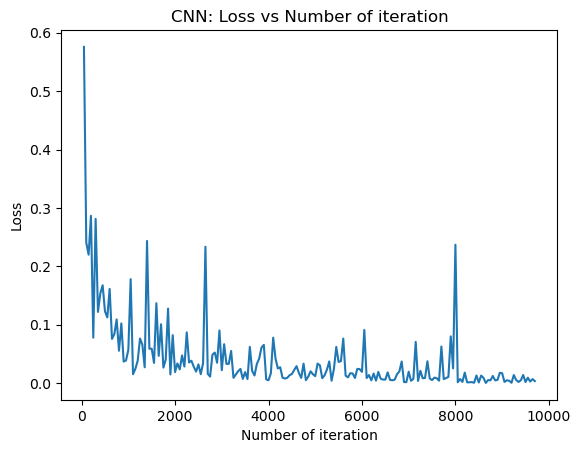

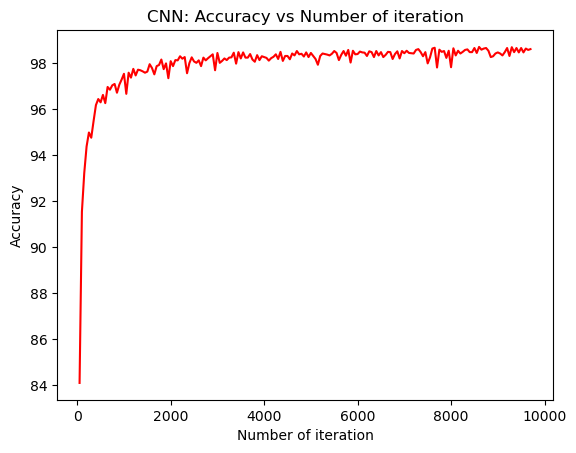

In [17]:
# visualization loss 
plt.plot(iteration_list,loss_list)
plt.xlabel("Number of iteration")
plt.ylabel("Loss")
plt.title("CNN: Loss vs Number of iteration")
plt.show()

# visualization accuracy 
plt.plot(iteration_list,accuracy_list,color = "red")
plt.xlabel("Number of iteration")
plt.ylabel("Accuracy")
plt.title("CNN: Accuracy vs Number of iteration")
plt.show()